In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


**Resources we used**

https://www.kaggle.com/code/abdulbasitniazi/word2vec-glove-a-beginner-s-guide
https://www.kaggle.com/code/prashantpathak244/sarcasm-detection-81
https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy/notebook

**Let's first import the librairies we are going to use**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn import decomposition
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from sklearn.metrics import precision_recall_fscore_support as score
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
import missingno as msno

In [3]:
!pip install pytorch-transformers
import torch
import torch.nn as nn
from pytorch_transformers import BertModel, BertTokenizer, BertConfig, WarmupLinearSchedule
import re
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm import tqdm, trange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 2.3 MB/s eta 0:00:00


**Loading Data**

In [4]:
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
del df['article_link'] 
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
df.shape

(26709, 2)

In [6]:
df2 = pd.read_json('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json' , lines = True)
del df2['article_link'] 
df2.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [7]:
df2.shape

(28619, 2)

**Seems like the 2 data sets we are given are different which will let us multiple way to test our models (we can use any of them and split it into train/test OR use one for train and the other for test)**

**Visualization**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

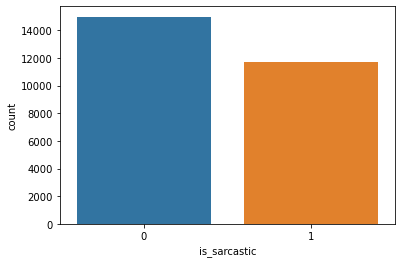

In [8]:
sns.countplot(df.is_sarcastic)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

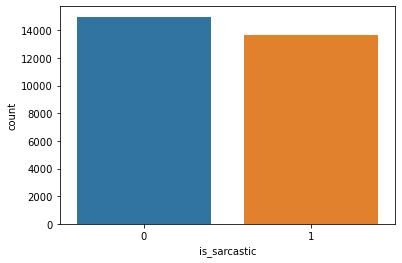

In [9]:
sns.countplot(df2.is_sarcastic)

**The data is balanced**

**WORDCLOUD FOR TEXT THAT IS NOT SARCASTIC (LABEL - 0)**

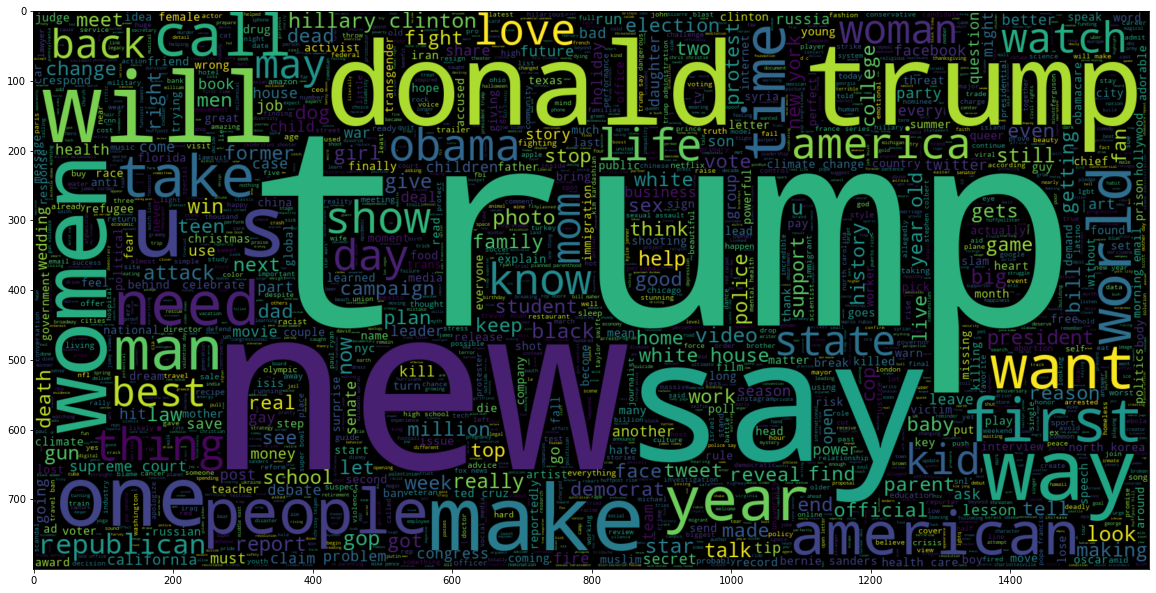

In [10]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

**WORDCLOUD FOR SARCASTIC TEXT (LABEL - 1)**

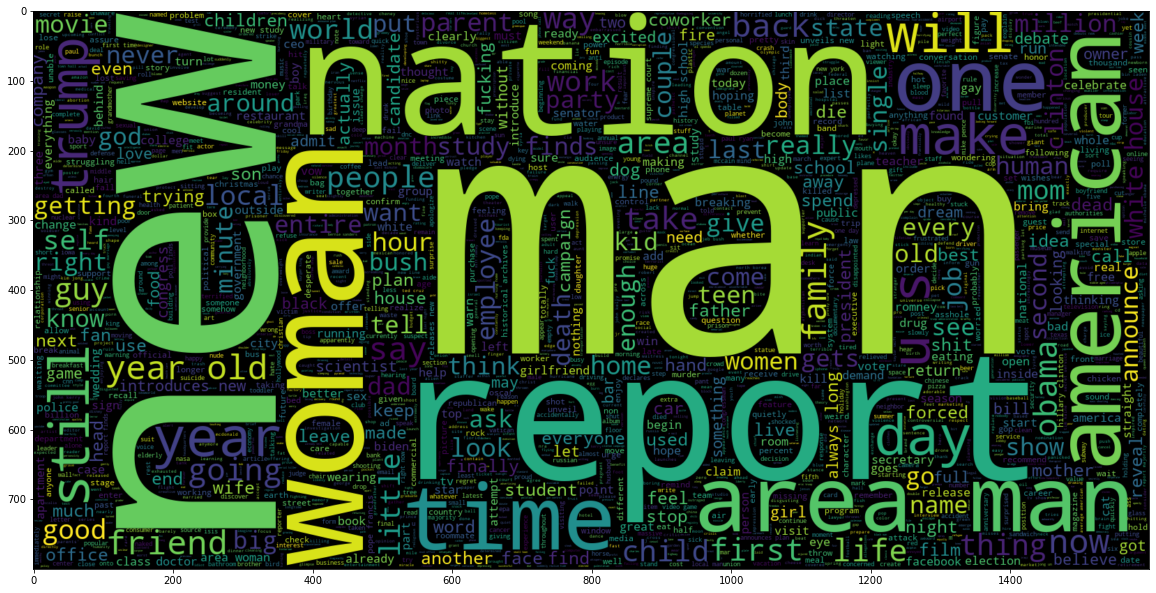

In [11]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

**Number of characters in texts**

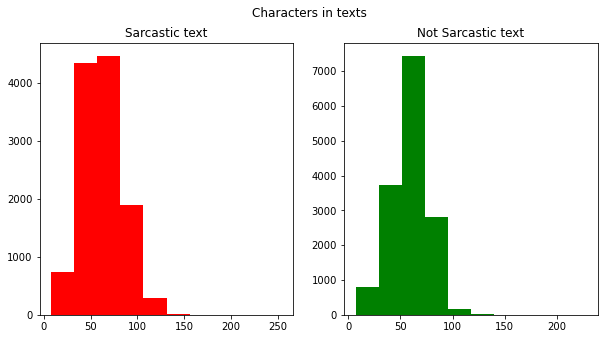

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

**Number of words in each text**

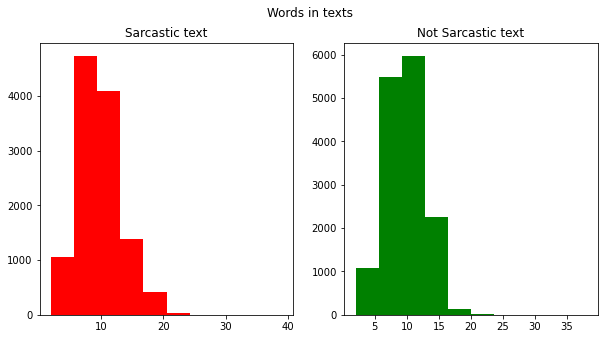

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

**Average word length in a text**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

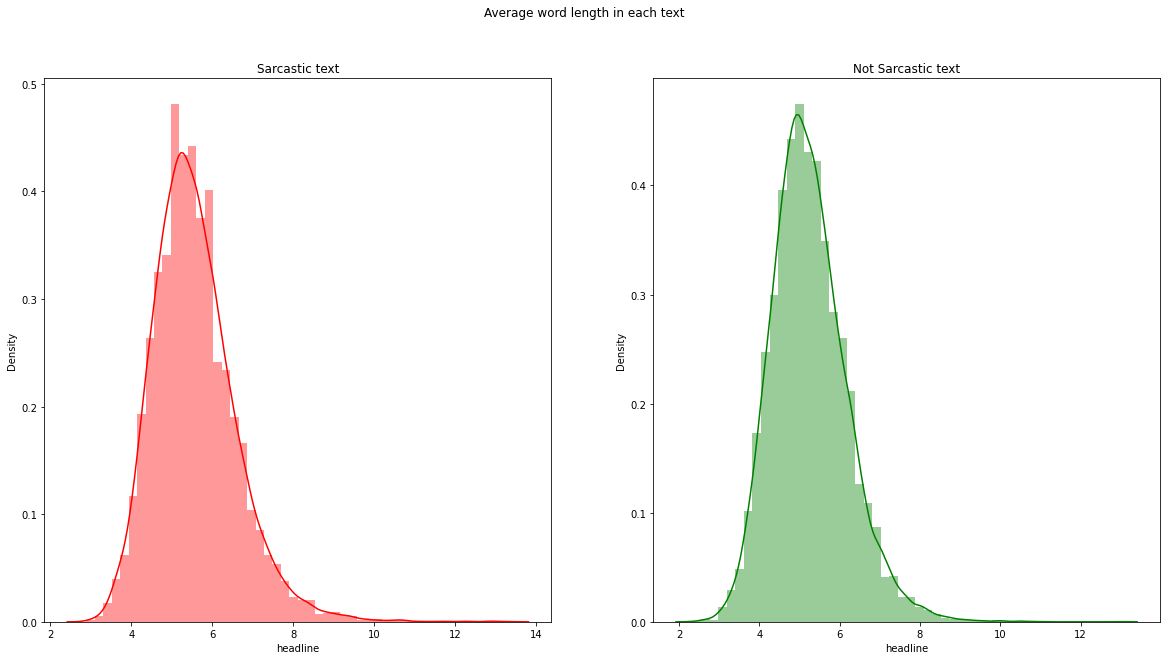

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

**Pre-processing**

In [15]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [16]:
df2.isna().sum()

is_sarcastic    0
headline        0
dtype: int64

**There isn't any missing values**

**topwords are the English words which does not add much meaning to a sentence**

In [17]:
#stopword removal 
stop = set(stopwords.words('english'))
p = list(string.punctuation)
stop.update(p)

**Basic Data Cleaning**

In [18]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_url(text):
    return re.sub('http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if (i.strip().lower() not in stop):
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [19]:
df['headline']=df['headline'].apply(denoise_text)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [20]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues secret 'black ...,0
1,'roseanne' revival catches thorny political mo...,0
2,mom starting fear son's web series closest thi...,1
3,"boehner wants wife listen, come alternative de...",1
4,j.k. rowling wishes snape happy birthday magic...,0


**We still have undesired punctuation like 'roseanne'**

In [21]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

In [22]:
df['headline']=df['headline'].apply(remove_punctuation)

In [23]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues secret black c...,0
1,roseanne revival catches thorny political mood...,0
2,mom starting fear sons web series closest thin...,1
3,boehner wants wife listen come alternative deb...,1
4,jk rowling wishes snape happy birthday magical...,0


In [24]:
df['headline'].iloc[45]

'christian bale visits sikh temple victims'

**It seems like we are done cleaning**

**We are going to use the first set (df) for the train/test split**

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df.headline, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [26]:
x_train.shape, x_test.shape

((18696,), (8013,))

**Let's start by testing some vectorizer and models**

**With CountVectorizer**

In [27]:
def algos_test_CountVectorizer(train_xs, test_xs, train_ys, test_ys):
    vectorizer = CountVectorizer()
    train_xs = vectorizer.fit_transform(train_xs)
    test_xs = vectorizer.transform(test_xs)

    algos = [
        LogisticRegression(),
        MultinomialNB(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(),
        xgb.XGBClassifier()
    ]
    results = []
    for algo in algos:
        print(algo)
        %timeit -n 1 -r 1 algo.fit(train_xs, train_ys)
        pred_ys = algo.predict(test_xs)
        results.append(
            {
                "algo": algo,
                "accuracy": accuracy_score(test_ys, pred_ys),
                "precision": score(test_ys, pred_ys, average="macro")[0],
                "recall": score(test_ys, pred_ys, average="macro")[1],
                "f1": score(test_ys, pred_ys, average="macro")[2],
            }
        )
    return pd.DataFrame.from_records(results)

results_CountVectorizer = algos_test_CountVectorizer(x_train, x_test, y_train, y_test)
results_CountVectorizer

LogisticRegression()
719 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
MultinomialNB()
18.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
DecisionTreeClassifier()
7.06 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
RandomForestClassifier()
29.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
SVC()
1min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None,

,algo,accuracy,precision,recall,f1
0,LogisticRegression(),0.794584,0.795300,0.785976,0.788773
1,MultinomialNB(),0.803819,0.802650,0.797662,0.799508
2,DecisionTreeClassifier(),0.727568,0.723628,0.722349,0.722900
3,"(DecisionTreeClassifier(max_features='auto', r...",0.753151,0.767181,0.734705,0.737730
4,SVC(),0.791089,0.803113,0.775958,0.780513
5,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.722326,0.756285,0.695473,0.693120


**With TfidVectorizer**

In [28]:
def algos_test_TfidVectorizer(train_xs, test_xs, train_ys, test_ys):
    vectorizer = TfidfVectorizer()
    train_xs = vectorizer.fit_transform(train_xs)
    test_xs = vectorizer.transform(test_xs)

    algos = [
        LogisticRegression(),
        MultinomialNB(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(),
        xgb.XGBClassifier()
    ]
    results = []
    for algo in algos:
        print(algo)
        %timeit -n 1 -r 1 algo.fit(train_xs, train_ys)
        pred_ys = algo.predict(test_xs)
        results.append(
            {
                "algo": algo,
                "accuracy": accuracy_score(test_ys, pred_ys),
                "precision": score(test_ys, pred_ys, average="macro")[0],
                "recall": score(test_ys, pred_ys, average="macro")[1],
                "f1": score(test_ys, pred_ys, average="macro")[2],
            }
        )
    return pd.DataFrame.from_records(results)

results_TfidVectorizer = algos_test_TfidVectorizer(x_train, x_test, y_train, y_test)
results_TfidVectorizer

LogisticRegression()
618 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
MultinomialNB()
13 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
DecisionTreeClassifier()
9.71 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
RandomForestClassifier()
27.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
SVC()
1min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_

,algo,accuracy,precision,recall,f1
0,LogisticRegression(),0.790715,0.794471,0.779658,0.783240
1,MultinomialNB(),0.792088,0.806503,0.776097,0.780818
2,DecisionTreeClassifier(),0.719206,0.715129,0.713281,0.714021
3,"(DecisionTreeClassifier(max_features='auto', r...",0.760015,0.765842,0.745807,0.749145
4,SVC(),0.796331,0.800844,0.785128,0.788904
5,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.716461,0.749430,0.689298,0.686236


**It seems like there isn't much of a difference between CountVectorizer and TfidVectorizer, and we got 80/79% accuracy with MultinomialNB model and SVC**

**Next things to try : word embedding with Word2Vec and Glove (expected to get better results by capturing the context)**

transformers

In [29]:
!pip install transformers

In [30]:
x_train, x_test, y_train, y_test = train_test_split(df.headline, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [31]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
import random

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
random.seed(RANDOM_SEED)

sentences = df.headline

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))


Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

 Original:  former versace store clerk sues secret black code minority shoppers
Tokenized:  ['former', 'versa', '##ce', 'store', 'clerk', 'sue', '##s', 'secret', 'black', 'code', 'minority', 'shop', '##pers']
Token IDs:  [2280, 18601, 3401, 3573, 7805, 9790, 2015, 3595, 2304, 3642, 7162, 4497, 7347]


In [32]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  41


In [33]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
labels = df.is_sarcastic
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  former versace store clerk sues secret black code minority shoppers
Token IDs: tensor([  101,  2280, 18601,  3401,  3573,  7805,  9790,  2015,  3595,  2304,
         3642,  7162,  4497,  7347,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [34]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

21,367 training samples
5,342 validation samples


In [35]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [36]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [37]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )



/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [38]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [39]:
import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to calculate the precision of our predictions vs labels
def flat_precision(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(labels_flat, pred_flat)

# Function to calculate the recall of our predictions vs labels
def flat_recall(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, pred_flat)

# Function to calculate the f1 score of our predictions vs labels
def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat)


In [40]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [41]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.

        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()


        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_precision = 0
    total_eval_recall = 0
    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.

            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = output.loss
            logits = output.logits
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_precision += flat_precision(logits, label_ids)
        total_eval_recall += flat_recall(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)

        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    avg_val_precision = total_eval_precision / len(validation_dataloader)
    print("  Precision: {0:.2f}".format(avg_val_precision))

    avg_val_recall = total_eval_recall / len(validation_dataloader)
    print("  Recall: {0:.2f}".format(avg_val_recall))

    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print("  F1: {0:.2f}".format(avg_val_f1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Valid. precision': avg_val_precision,
            'Valid. recall': avg_val_recall,
            'Valid. F1': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
            
            
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    668.    Elapsed: 0:00:14.
  Batch    80  of    668.    Elapsed: 0:00:27.
  Batch   120  of    668.    Elapsed: 0:00:39.
  Batch   160  of    668.    Elapsed: 0:00:52.
  Batch   200  of    668.    Elapsed: 0:01:05.
  Batch   240  of    668.    Elapsed: 0:01:18.
  Batch   280  of    668.    Elapsed: 0:01:31.
  Batch   320  of    668.    Elapsed: 0:01:44.
  Batch   360  of    668.    Elapsed: 0:01:57.
  Batch   400  of    668.    Elapsed: 0:02:11.
  Batch   440  of    668.    Elapsed: 0:02:24.
  Batch   480  of    668.    Elapsed: 0:02:38.
  Batch   520  of    668.    Elapsed: 0:02:51.
  Batch   560  of    668.    Elapsed: 0:03:04.
  Batch   600  of    668.    Elapsed: 0:03:18.
  Batch   640  of    668.    Elapsed: 0:03:31.

  Average training loss: 0.44
  Training epcoh took: 0:03:40

Running Validation...
  Accuracy: 0.85
  Precision: 0.88
  Recall: 0.77
  F1: 0.81
  Validation Loss: 0.34
  Validation took: 0:00:19

=======

In [42]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Valid. precision,Valid. recall,Valid. F1,Training Time,Validation Time
epoch,,,,,,,,
1,0.44,0.34,0.85,0.88,0.77,0.81,0:03:40,0:00:19
2,0.25,0.33,0.87,0.86,0.82,0.84,0:03:44,0:00:19
3,0.14,0.40,0.87,0.87,0.82,0.84,0:03:44,0:00:19
4,0.09,0.51,0.88,0.86,0.86,0.85,0:03:44,0:00:19


([<matplotlib.axis.XTick at 0x7f4482836b90>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

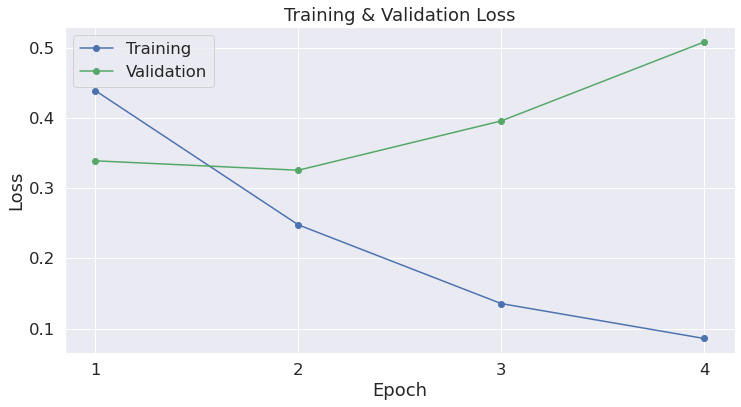

In [43]:
import matplotlib.pyplot as plt


import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])


In [44]:
fp = np.where((logits[:,0] > logits[:,1]) & (label_ids == 1))[0]
fn = np.where((logits[:,0] < logits[:,1]) & (label_ids == 0))[0]
print("False Positive: ", fp)
print("False Negative: ", fn)
print("False Positive Text: ", df.loc[fp, 'headline'])
print("False Negative Text: ", df.loc[fn,'headline'])
    


False Positive:  [21 27]
False Negative:  [12 24]
False Positive Text:  21    trump assures nation decision syrian airstrike...
27                                excon back behind bar
Name: headline, dtype: object
False Negative Text:  12    north korea praises trump urges us voters reje...
24    ted cruz hits panic button we could lose house...
Name: headline, dtype: object


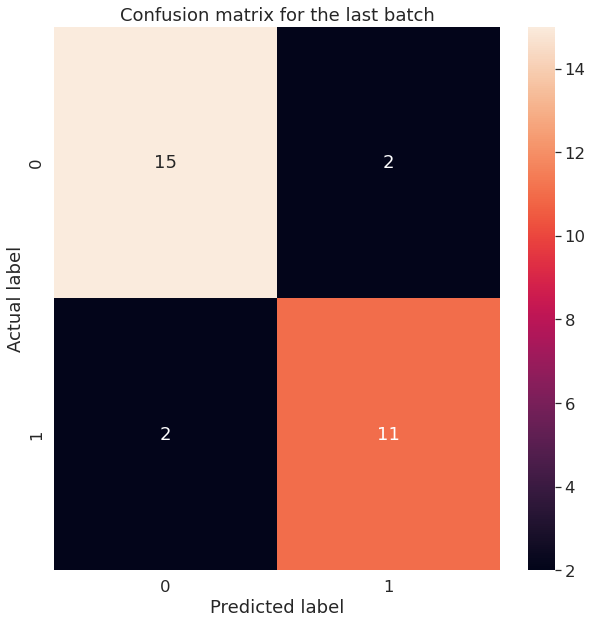

In [45]:
y_pred = np.argmax(logits, axis=1)
cm = confusion_matrix(label_ids, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix for the last batch')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [46]:
df.loc[24, 'headline']

'ted cruz hits panic button we could lose houses congress'

In [47]:
df.loc[fn,'headline']

12    north korea praises trump urges us voters reje...
24    ted cruz hits panic button we could lose house...
Name: headline, dtype: object